In [1]:
import pandas as pd
import anndata as ad
import numpy as np
import os
import re
import seaborn as sns
import argparse
import scanpy as sc
from matplotlib import cm
import matplotlib.pyplot as plt
from src.classes import *

In [2]:
sns.set(rc={'figure.figsize':(8,5)})

In [3]:
file = '../../results/Batch_corrections/seurat/TX_mt_kept/TX_st_adata_cluster.h5ad'
output = f'{file.split(".h5ad")[0]}_regions.h5ad'
adata = sc.read_h5ad(file)
adata.obs['cluster'] = adata.obs['cluster'].astype('str')
adata, output

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(AnnData object with n_obs × n_vars = 8206 × 15172
     obs: 'feature', 'orig_feature', 'array_row', 'array_col', 'in_tissue', 'sample', 'slide', 'median_gene_feature', 'median_transcript_feature', 'x', 'y', 'new_x', 'new_y', 'pixel_x', 'pixel_y', 'n_transcripts', 'MT_perc', 'ribo_perc', 'G_content', 'RNOG_content', 'cluster', 'umap1', 'umap2'
     var: 'ensembl_id', 'name', 'gene_id', 'species', 'value', 'Gene_no_alt', 'MT', 'ribo'
     uns: 'merged', 'sample', 'spatial'
     obsm: 'spatial',
 '../../results/Batch_corrections/seurat/TX_mt_kept/TX_st_adata_cluster_regions.h5ad')

In [4]:
samples = adata.obs['sample'].unique()

In [5]:
adata_norm = adata.copy()
sc.pp.normalize_total(adata_norm)
sc.pp.log1p(adata_norm)

TH in var
vmax = 0.0


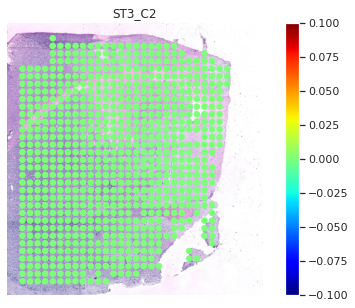

TH in var
vmax = 1.475456953048706


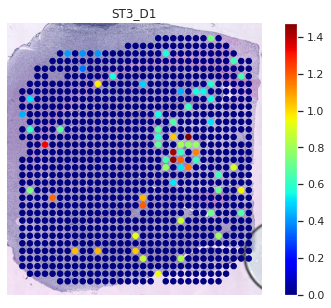

TH in var
vmax = 1.561748743057251


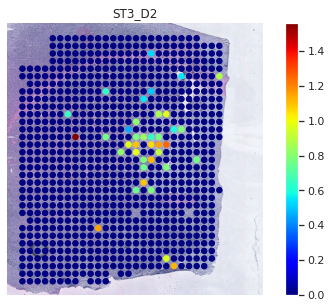

TH in var
vmax = 1.7013497352600098


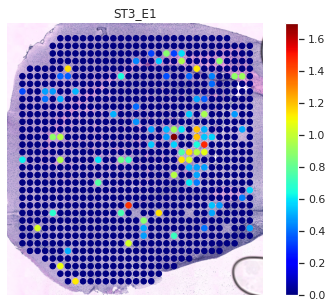

TH in var
vmax = 0.0


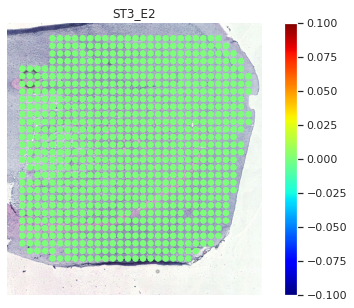

TH in var
vmax = 0.0


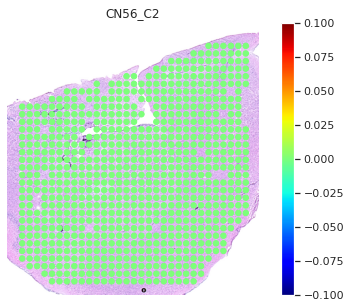

TH in var
vmax = 1.294461727142334


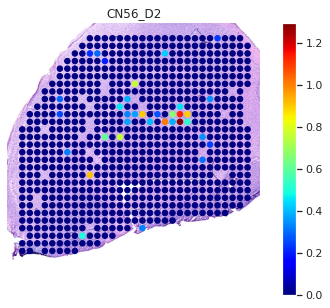

TH in var
vmax = 2.0881636142730713


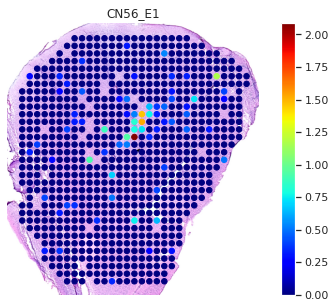

TH in var
vmax = 1.6614415645599365


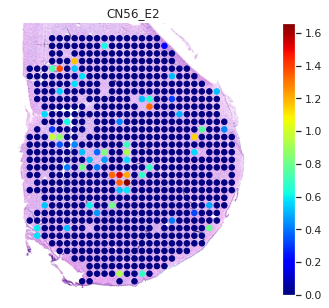

TH in var
vmax = 2.035745620727539


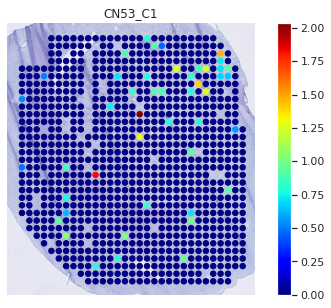

<Figure size 576x360 with 0 Axes>

In [6]:
for sample in samples:
    plot_ST(adata_norm, sample, show=True, output=False, feat_max=[34, 32], 
            color='TH', s=30, vmax_global=False)

In [20]:
region_marker_dict= {'STR': ['PENK', 'ADORA2A', 'PPP1R1B'],
                     'SN': ['TH', 'PBX1', 'SLC6A3', 'ALDH1A1', 'DDC', 'RET'],
                     'CC': ['MBP'],
                    'CTX': ['CCK', 'KCNC2']}
adata.uns['regions_dict'] = dict()

In [8]:
# detect human  regions
def detect_human_regions(adata, cutoff=0.15):
    cluster_human_content = adata.obs.groupby('cluster').mean()
    cluster_human_content = cluster_human_content[cluster_human_content['G_content'] > cutoff]

    max_human = cluster_human_content[cluster_human_content['G_content'] == cluster_human_content['G_content'].max()].index
    partial = [x for x in cluster_human_content.index if x not in max_human]
    adata.obs['partial_human'] = [True if x in partial else False for x in adata.obs.cluster]
    # adata_no_partial = adata.copy()
    # #adata_no_partial = adata_no_partial[adata_no_partial.obs.partial_human == False, :]
    # print(adata_no_partial.X)
    adata.obs['TX'] = [True if x in max_human else False for x in adata.obs.cluster]
    adata.uns['regions'] = ['TX']

    for cluster in max_human:
        adata.uns['regions_dict'][str(cluster)] = 'TX'
        
def remove_partial_cluster(adata, column='partial_human'):
    adata = adata[adata.obs[column] == False, :]    
    return adata

In [9]:
detect_human_regions(adata)
adata.obs['TX'].value_counts()

/tmp/ipykernel_4636/903499781.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_human_content = adata.obs.groupby('cluster').mean()


False    7961
True      245
Name: TX, dtype: int64

In [10]:
def detect_noisy_samples(obs_df, column='G_content', region='TX'):
    score_df = pd.DataFrame(columns=['sample', 'TX_score', 'non_TX_score', 'diff_score'])
    for sample in obs_df['sample'].unique():
        non_TX_score = obs_df.loc[(obs_df['sample'] == sample) & (obs_df[region] == 0)][column].mean()
        TX_score = obs_df.loc[(obs_df['sample'] == sample) & (obs_df[region] == 1)][column].mean()
#         print(TX_score, non_TX_score)
        score_df.loc[len(score_df)] = [sample, TX_score, non_TX_score, (TX_score - non_TX_score)]
    return score_df

In [11]:
score_df = detect_noisy_samples(adata.obs)
score_df.sort_values(by='diff_score')

sample  TX_score  non_TX_score  diff_score
5  CN56_C2  0.318384      0.202584    0.115799
6  CN56_D2  0.267261      0.140354    0.126907
7  CN56_E1  0.255281      0.111174    0.144107
8  CN56_E2  0.272926      0.071083    0.201843
9  CN53_C1  0.281142      0.077497    0.203645
1   ST3_D1  0.354889      0.055738    0.299151
2   ST3_D2  0.352495      0.041647    0.310849
3   ST3_E1  0.389309      0.061961    0.327348
0   ST3_C2  0.481708      0.044702    0.437006
4   ST3_E2  0.507275      0.051749    0.455527

In [13]:
keep_samples = score_df[score_df['non_TX_score'] < 0.20]['sample']
# print(keep_samples)
adata_QC = adata[adata.obs['sample'].isin(keep_samples), :]
adata_QC.obs['sample'].unique()

['ST3_C2', 'ST3_D1', 'ST3_D2', 'ST3_E1', 'ST3_E2', 'CN56_D2', 'CN56_E1', 'CN56_E2', 'CN53_C1']
Categories (9, object): ['CN53_C1', 'CN56_D2', 'CN56_E1', 'CN56_E2', ..., 'ST3_D1', 'ST3_D2', 'ST3_E1', 'ST3_E2']

In [21]:
def create_pseudobulk(adata, groupby='cluster', separateby='sample'):
    replicates = adata.obs[separateby].unique()
    obs_cols = adata.obs.columns
    pseudobulk_df = pd.DataFrame()
    for replicate in replicates:
        print('creating pseudobulk for', replicate)
        replicate_adata = adata[adata.obs[separateby] == replicate, :]
        gene_df = pd.DataFrame(replicate_adata.X,
                               columns=replicate_adata.var.index.to_list(),
                               index=replicate_adata.obs[groupby])
        gene_df = gene_df.groupby(groupby).sum()
        obs_df = replicate_adata.obs.groupby(groupby).mean()
        replicate_df = pd.concat([obs_df, gene_df], axis=1)
        replicate_df[separateby] = replicate
        replicate_df = replicate_df.reset_index()
        pseudobulk_df = pseudobulk_df.append(replicate_df)
    adata_pseudobulk = ad.AnnData(X=np.array(pseudobulk_df[replicate_adata.var.index.to_list()]),
                                  obs=pseudobulk_df[[x for x in pseudobulk_df.columns if x in obs_cols]],
                                  var=replicate_adata.var)
    adata_pseudobulk.uns = adata.uns

    return adata_pseudobulk

In [40]:
adata_pseudo = create_pseudobulk(adata_QC)
adata_pseudo.obs

creating pseudobulk for ST3_C2
creating pseudobulk for ST3_D1
creating pseudobulk for ST3_D2
creating pseudobulk for ST3_E1


/tmp/ipykernel_4636/3466527173.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  obs_df = replicate_adata.obs.groupby(groupby).mean()
/tmp/ipykernel_4636/3466527173.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pseudobulk_df = pseudobulk_df.append(replicate_df)
/tmp/ipykernel_4636/3466527173.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  obs_df = replicate_adata.obs.groupby(groupby).mean()
/tmp/ipykernel_4636/3466527173.py:16: FutureWarning: The frame.append method is deprecated and will be removed from 

creating pseudobulk for ST3_E2
creating pseudobulk for CN56_D2
creating pseudobulk for CN56_E1
creating pseudobulk for CN56_E2


/tmp/ipykernel_4636/3466527173.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  obs_df = replicate_adata.obs.groupby(groupby).mean()
/tmp/ipykernel_4636/3466527173.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pseudobulk_df = pseudobulk_df.append(replicate_df)
/tmp/ipykernel_4636/3466527173.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  obs_df = replicate_adata.obs.groupby(groupby).mean()
/tmp/ipykernel_4636/3466527173.py:16: FutureWarning: The frame.append method is deprecated and will be removed from 

creating pseudobulk for CN53_C1


/tmp/ipykernel_4636/3466527173.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  obs_df = replicate_adata.obs.groupby(groupby).mean()
/tmp/ipykernel_4636/3466527173.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pseudobulk_df = pseudobulk_df.append(replicate_df)
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_na

cluster  array_row  array_col  in_tissue  median_gene_feature  \
0        1  11.161826  16.995851        1.0               1409.0   
1       10   5.800000  31.333333        1.0               1409.0   
2       11  20.571429  17.285714        1.0               1409.0   
3        2  13.253968  26.071429        1.0               1409.0   
4        3  14.394737   8.144737        1.0               1409.0   
..     ...        ...        ...        ...                  ...   
6        5  13.466667   5.333333        1.0               2636.0   
7        6  11.732394  13.661972        1.0               2636.0   
8        7  18.206897   4.724138        1.0               2636.0   
9        8  16.050000  16.800000        1.0               2636.0   
10       9  26.655172   7.241379        1.0               2636.0   

    median_transcript_feature          x          y      new_x      new_y  \
0                      2671.0  11.161826  16.995851  11.116266  17.044979   
1                      2671.0   5.800000  31.333333   5.772000  31.343333   
2                      2671.0  20.571429  17.285714  20.540714  17.331429   
3                      2671.0  13.253968  26.071429  13.220159  26.093254   
4                      2671.0  14.394737   8.144737  14.342895   8.228553   
..                        ...        ...        ...        ...        ...   
6                      5573.0  13.466667   5.333333  13.572000   5.439333   
7                      5573.0  11.732394  13.661972  11.918451  13.733803   
8                      5573.0  18.206897   4.724138  18.126552   4.823448   
9                      5573.0  16.050000  16.800000  16.093750  16.875000   
10                     5573.0  26.655172   7.241379  26.742069   7.303448   

    ...     umap2  partial_human   TX  STR_score_pseudo  STR_pseudo  \
0   ...  0.158809            0.0  0.0          1.960769         1.0   
1   ... -3.440363            0.0  0.0         -0.562355         0.0   
2   ...  1.590710            0.0  0.0          0.644462         0.0   
3   ...  0.173529            0.0  0.0         -0.404511         0.0   
4   ... -1.689001            0.0  0.0         -0.613957         0.0   
..  ...       ...            ...  ...               ...         ...   
6   ...  5.466217            0.0  0.0          0.171494         0.0   
7   ...  4.818026            0.0  0.0         -0.043088         0.0   
8   ...  2.686584            0.0  0.0          1.213158         1.0   
9   ... -1.650085            0.0  0.0          0.617666         0.0   
10  ... -5.436386            0.0  1.0          0.365394         0.0   

    CTX_pseudo  G_content_pseudo  RNOG_content_pseudo  CC_pseudo   sample  
0          0.0          0.049223             0.950777        0.0   ST3_C2  
1          0.0          0.034089             0.965911        0.0   ST3_C2  
2          0.0          0.069577             0.930423        0.0   ST3_C2  
3          0.0          0.042182             0.957818        0.0   ST3_C2  
4          1.0          0.041570             0.958430        0.0   ST3_C2  
..         ...               ...                  ...        ...      ...  
6          0.0          0.074129             0.925871        0.0  CN53_C1  
7          0.0          0.073067             0.926933        1.0  CN53_C1  
8          0.0          0.088209             0.911791        0.0  CN53_C1  
9          0.0          0.076437             0.923563        0.0  CN53_C1  
10         0.0          0.281142             0.718858        0.0  CN53_C1  

[99 rows x 28 columns]

In [42]:
def select_regions_clusters(adata, region_marker_dict, regions=['STR'], cutoff=0.75):
    "expects log!"
    adata.raw = adata.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    for region in regions:
        print(region)
        
        adata.obs[region + '_score'] = list(np.mean(adata[:, region_marker_dict[region]].X, axis=1))
        adata.obs[region + '_score'] = adata.obs[region + '_score']-adata.obs[region + '_score'].mean()
        adata.obs[region + '_score'] = adata.obs[region + '_score']/adata.obs[region + '_score'].std()

        score = adata.obs.groupby('cluster').mean()        
#         if region == 'CTX':
#             score[region] = score[region + '_score'] > 1
#         else:
        score[region] = score[region + '_score'] > cutoff
        cluster_region_map = dict(score[region])
#         print(cluster_region_map)
        adata.obs[region] = adata.obs['cluster'].map(cluster_region_map)
        for cluster, value in cluster_region_map.items():
            if value == True and cluster not in adata.uns['regions_dict'].keys():
                    adata.uns['regions_dict'][str(cluster)] = region

    adata.uns['regions'] = adata.uns['regions'] + regions
    adata.X = adata.raw.to_adata().X
   

    return adata

In [32]:
# adata_pseudo.raw = adata_pseudo.copy()
# sc.pp.normalize_total(adata_pseudo)
# sc.pp.log1p(adata_pseudo)

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [43]:
adata_pseudo = select_regions_clusters(adata_pseudo, 
                                       region_marker_dict=region_marker_dict, 
                                       regions=['STR', 'CTX', 'CC'])

adata_pseudo.obs

STR
CTX
CC


/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_4636/2927215353.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score = adata.obs.groupby('cluster').mean()
/tmp/ipykernel_4636/2927215353.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  score = adata.obs.groupby('cluster').mean()
/tmp/ipykernel_4636/2927215353.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprec

cluster  array_row  array_col  in_tissue  median_gene_feature  \
0        1  11.161826  16.995851        1.0               1409.0   
1       10   5.800000  31.333333        1.0               1409.0   
2       11  20.571429  17.285714        1.0               1409.0   
3        2  13.253968  26.071429        1.0               1409.0   
4        3  14.394737   8.144737        1.0               1409.0   
..     ...        ...        ...        ...                  ...   
6        5  13.466667   5.333333        1.0               2636.0   
7        6  11.732394  13.661972        1.0               2636.0   
8        7  18.206897   4.724138        1.0               2636.0   
9        8  16.050000  16.800000        1.0               2636.0   
10       9  26.655172   7.241379        1.0               2636.0   

    median_transcript_feature          x          y      new_x      new_y  \
0                      2671.0  11.161826  16.995851  11.116266  17.044979   
1                      2671.0   5.800000  31.333333   5.772000  31.343333   
2                      2671.0  20.571429  17.285714  20.540714  17.331429   
3                      2671.0  13.253968  26.071429  13.220159  26.093254   
4                      2671.0  14.394737   8.144737  14.342895   8.228553   
..                        ...        ...        ...        ...        ...   
6                      5573.0  13.466667   5.333333  13.572000   5.439333   
7                      5573.0  11.732394  13.661972  11.918451  13.733803   
8                      5573.0  18.206897   4.724138  18.126552   4.823448   
9                      5573.0  16.050000  16.800000  16.093750  16.875000   
10                     5573.0  26.655172   7.241379  26.742069   7.303448   

    ...  G_content_pseudo  RNOG_content_pseudo  CC_pseudo   sample  STR_score  \
0   ...          0.049223             0.950777        0.0   ST3_C2   1.974262   
1   ...          0.034089             0.965911        0.0   ST3_C2  -0.563814   
2   ...          0.069577             0.930423        0.0   ST3_C2   0.645744   
3   ...          0.042182             0.957818        0.0   ST3_C2  -0.423417   
4   ...          0.041570             0.958430        0.0   ST3_C2  -0.591946   
..  ...               ...                  ...        ...      ...        ...   
6   ...          0.074129             0.925871        0.0  CN53_C1   0.142350   
7   ...          0.073067             0.926933        1.0  CN53_C1  -0.053040   
8   ...          0.088209             0.911791        0.0  CN53_C1   1.188844   
9   ...          0.076437             0.923563        0.0  CN53_C1   0.633055   
10  ...          0.281142             0.718858        0.0  CN53_C1   0.343068   

      STR  CTX_score    CTX  CC_score     CC  
0    True  -1.015913  False  0.174051  False  
1   False  -0.534740  False -1.770668  False  
2   False  -0.253856  False  0.281168  False  
3   False   0.620908  False  0.456891  False  
4   False   2.139179   True  0.704705  False  
..    ...        ...    ...       ...    ...  
6   False  -0.580731  False  0.011334  False  
7   False  -0.408378  False  1.375787   True  
8    True  -1.129982  False -0.226940  False  
9   False   0.254752  False  0.310737  False  
10  False  -1.622601  False  0.164958  False  

[99 rows x 34 columns]

In [44]:
adata_pseudo.obs['pseubobuk_cluster'] = adata_pseudo.obs['sample'].astype('str') + '_' + adata_pseudo.obs['cluster'].astype('str')
adata_QC.obs['pseubobuk_cluster'] = adata_QC.obs['sample'].astype('str') + '_' + adata_QC.obs['cluster'].astype('str')
cols_to_add = ['pseubobuk_cluster', 'STR_score', 'STR', 'CTX', 'CC', 'G_content', 'RNOG_content']
pseudo_np = adata_pseudo.obs[cols_to_add].to_numpy()
# print(pseudo_np)
for idx, col in enumerate(cols_to_add[1:]):
    pseudo_cluster_mapping = {col:attr for col, attr in pseudo_np[:, [0, idx + 1]]}
    adata_QC.obs[f'{cols_to_add[idx + 1]}_pseudo'] = adata_QC.obs['pseubobuk_cluster'].map(pseudo_cluster_mapping)
adata_QC.obs

feature orig_feature  array_row  array_col  in_tissue   sample  \
0      X4.95_14.07        X5_14        5.0       14.0          1   ST3_C2   
1      X4.95_11.06        X5_11        5.0       11.0          1   ST3_C2   
2     X15.94_14.05       X16_14       16.0       14.0          1   ST3_C2   
3      X8.01_14.97        X8_15        8.0       15.0          1   ST3_C2   
4     X10.91_24.02       X11_24       11.0       24.0          1   ST3_C2   
...            ...          ...        ...        ...        ...      ...   
8201  X19.95_20.05       X20_20       20.0       20.0          1  CN53_C1   
8202  X23.22_30.02       X23_30       23.0       30.0          1  CN53_C1   
8203  X19.85_13.09       X20_13       20.0       13.0          1  CN53_C1   
8204   X24.1_26.01       X24_26       24.0       26.0          1  CN53_C1   
8205  X14.81_30.96       X15_31       15.0       31.0          1  CN53_C1   

     slide  median_gene_feature  median_transcript_feature   x  ...     umap2  \
0      ST3               1409.0                     2671.0   5  ... -0.785746   
1      ST3               1409.0                     2671.0   5  ... -1.173644   
2      ST3               1409.0                     2671.0  16  ... -0.855115   
3      ST3               1409.0                     2671.0   8  ... -1.389697   
4      ST3               1409.0                     2671.0  11  ...  2.138189   
...    ...                  ...                        ...  ..  ...       ...   
8201  CN53               2636.0                     5573.0  20  ...  0.500053   
8202  CN53               2636.0                     5573.0  23  ... -3.560959   
8203  CN53               2636.0                     5573.0  20  ...  1.479813   
8204  CN53               2636.0                     5573.0  24  ... -0.016068   
8205  CN53               2636.0                     5573.0  15  ... -4.115334   

      partial_human     TX  pseubobuk_cluster  STR_score_pseudo  STR_pseudo  \
0             False  False           ST3_C2_1          1.974262        True   
1             False  False           ST3_C2_3         -0.591946       False   
2             False  False           ST3_C2_1          1.974262        True   
3             False  False           ST3_C2_1          1.974262        True   
4             False  False           ST3_C2_1          1.974262        True   
...             ...    ...                ...               ...         ...   
8201          False  False          CN53_C1_1          1.270121        True   
8202          False  False          CN53_C1_4         -0.649399       False   
8203          False  False          CN53_C1_1          1.270121        True   
8204          False  False          CN53_C1_2         -0.157665       False   
8205          False  False          CN53_C1_4         -0.649399       False   

      CTX_pseudo  G_content_pseudo  RNOG_content_pseudo  CC_pseudo  
0          False          0.049223             0.950777      False  
1           True          0.041570             0.958430      False  
2          False          0.049223             0.950777      False  
3          False          0.049223             0.950777      False  
4          False          0.049223             0.950777      False  
...          ...               ...                  ...        ...  
8201       False          0.082214             0.917786      False  
8202        True          0.068916             0.931084      False  
8203       False          0.082214             0.917786      False  
8204       False          0.078840             0.921160      False  
8205        True          0.068916             0.931084      False  

[7409 rows x 32 columns]

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 2., 1., 0., 0.,
        2., 1., 2., 0., 1., 2., 2., 1., 4., 3., 1., 4., 3., 3., 2., 1., 5.,
        3., 0., 1., 4., 1., 0., 1., 2., 0., 1., 1., 3., 1., 0., 3., 0., 4.,
        1., 2., 1., 2., 0., 0., 1., 1., 0., 2., 0., 0., 1., 2., 1., 1., 0.,
        3., 0., 0., 1., 1., 4., 1., 1., 1., 0., 0., 0., 0., 0., 1.]),
 array([-2.8284423 , -2.7787662 , -2.72909   , -2.6794138 , -2.6297374 ,
        -2.5800612 , -2.530385  , -2.4807088 , -2.4310327 , -2.3813565 ,
        -2.3316803 , -2.2820039 , -2.2323277 , -2.1826515 , -2.1329753 ,
        -2.0832992 , -2.033623  , -1.9839467 , -1.9342705 , -1.8845942 ,
        -1.834918  , -1.7852418 , -1.7355655 , -1.6858894 , -1.6362132 ,
        -1.5865369 , -1.5368607 , -1.4871845 , -1.4375083 , -1.387832  ,
        -1.3381559 , -1.2884797 , -1.2388034 , -1.1891272 , -1.139451  ,
        -1.0897748 , -1.0400985 , -0.99

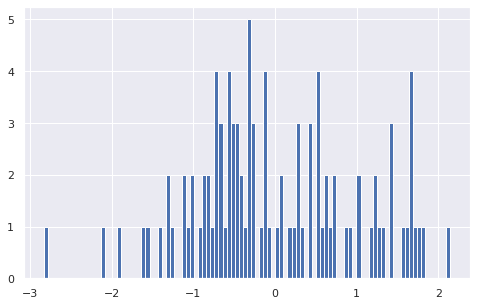

In [50]:
plt.hist(adata_pseudo.obs['CTX_score'].to_numpy(), bins=100)

vmax = 1.0


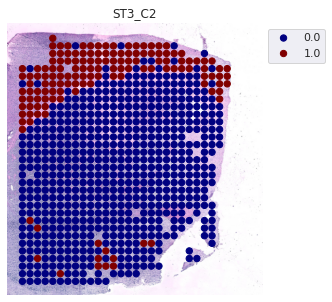

vmax = 1.0


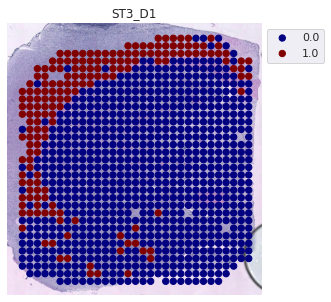

vmax = 1.0


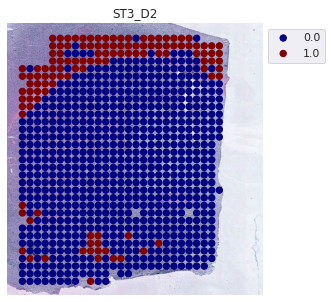

vmax = 1.0


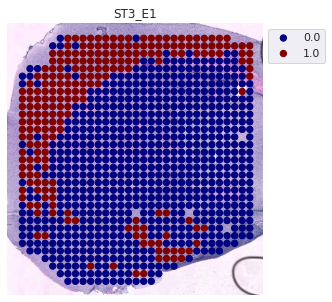

vmax = 1.0


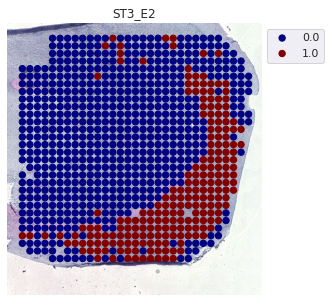

vmax = 1.0


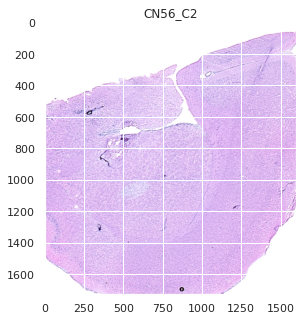

vmax = 1.0


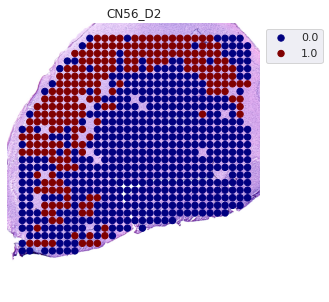

vmax = 1.0


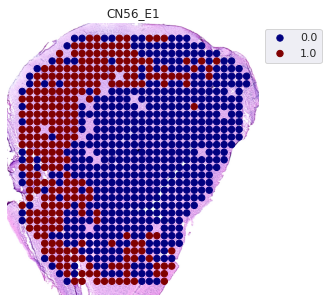

vmax = 1.0


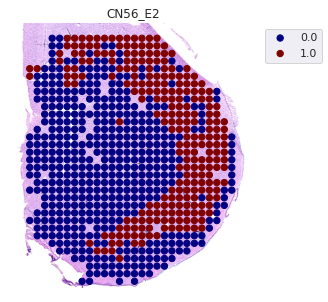

vmax = 1.0


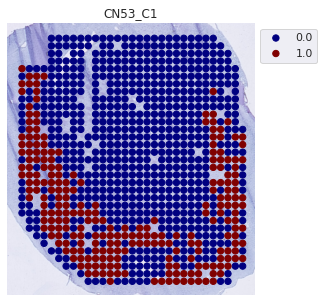

<Figure size 576x360 with 0 Axes>

In [45]:
for sample in samples:
    plot_ST(adata_QC, color = 'CTX_pseudo', sample = sample)

In [109]:
adata_pseudo.obs['region'] = adata_pseudo.obs.cluster.map(adata_pseudo.uns['regions_dict']).astype('str')
adata_pseudo.obs.region = adata_pseudo.obs['region'].str.replace('nan', 'other')
adata_pseudo.obs.region = adata_pseudo.obs.region.astype('category')
adata_pseudo

AnnData object with n_obs × n_vars = 99 × 15172
    obs: 'cluster', 'array_row', 'array_col', 'in_tissue', 'median_gene_feature', 'median_transcript_feature', 'x', 'y', 'new_x', 'new_y', 'pixel_x', 'pixel_y', 'n_transcripts', 'MT_perc', 'ribo_perc', 'G_content', 'RNOG_content', 'umap1', 'umap2', 'partial_human', 'TX', 'sample', 'STR_score', 'STR', 'CTX_score', 'CTX', 'pseubobuk_cluster', 'region'
    var: 'ensembl_id', 'name', 'gene_id', 'species', 'value', 'Gene_no_alt', 'MT', 'ribo'
    uns: 'merged', 'sample', 'spatial', 'regions_dict', 'regions'

In [26]:
adata_QC.obs['region'] = adata_QC.obs['cluster'].map(adata_pseudo.uns['regions_dict'])
adata_QC.obs['region'].fillna('other', inplace=True)
adata_QC.obs['region'].value_counts()

other    4456
STR      2086
CTX       624
TX        243
Name: region, dtype: int64

In [68]:
adata_pseudo.write_h5ad(output)

In [110]:
adata_pseudo.obs.index = adata_pseudo.obs['sample'] + '-' + adata_pseudo.obs['cluster']
adata_pseudo.obs

cluster  array_row  array_col  in_tissue  median_gene_feature  \
ST3_C2-1        1  11.161826  16.995851        1.0               1409.0   
ST3_C2-10      10   5.800000  31.333333        1.0               1409.0   
ST3_C2-11      11  20.571429  17.285714        1.0               1409.0   
ST3_C2-2        2  13.253968  26.071429        1.0               1409.0   
ST3_C2-3        3  14.394737   8.144737        1.0               1409.0   
...           ...        ...        ...        ...                  ...   
CN53_C1-5       5  13.466667   5.333333        1.0               2636.0   
CN53_C1-6       6  11.732394  13.661972        1.0               2636.0   
CN53_C1-7       7  18.206897   4.724138        1.0               2636.0   
CN53_C1-8       8  16.050000  16.800000        1.0               2636.0   
CN53_C1-9       9  26.655172   7.241379        1.0               2636.0   

           median_transcript_feature          x          y      new_x  \
ST3_C2-1                      2671.0  11.161826  16.995851  11.116266   
ST3_C2-10                     2671.0   5.800000  31.333333   5.772000   
ST3_C2-11                     2671.0  20.571429  17.285714  20.540714   
ST3_C2-2                      2671.0  13.253968  26.071429  13.220159   
ST3_C2-3                      2671.0  14.394737   8.144737  14.342895   
...                              ...        ...        ...        ...   
CN53_C1-5                     5573.0  13.466667   5.333333  13.572000   
CN53_C1-6                     5573.0  11.732394  13.661972  11.918451   
CN53_C1-7                     5573.0  18.206897   4.724138  18.126552   
CN53_C1-8                     5573.0  16.050000  16.800000  16.093750   
CN53_C1-9                     5573.0  26.655172   7.241379  26.742069   

               new_y  ...     umap2  partial_human   TX   sample  STR_score  \
ST3_C2-1   17.044979  ...  0.158809            0.0  0.0   ST3_C2   1.267183   
ST3_C2-10  31.343333  ... -3.440363            0.0  0.0   ST3_C2  -0.592355   
ST3_C2-11  17.331429  ...  1.590710            0.0  0.0   ST3_C2  -0.578759   
ST3_C2-2   26.093254  ...  0.173529            0.0  0.0   ST3_C2  -0.467520   
ST3_C2-3    8.228553  ... -1.689001            0.0  0.0   ST3_C2  -0.492240   
...              ...  ...       ...            ...  ...      ...        ...   
CN53_C1-5   5.439333  ...  5.466217            0.0  0.0  CN53_C1  -0.560219   
CN53_C1-6  13.733803  ...  4.818026            0.0  0.0  CN53_C1  -0.391507   
CN53_C1-7   4.823448  ...  2.686584            0.0  0.0  CN53_C1  -0.253695   
CN53_C1-8  16.875000  ... -1.650085            0.0  0.0  CN53_C1  -0.440329   
CN53_C1-9   7.303448  ... -5.436386            0.0  1.0  CN53_C1  -0.479880   

             STR  CTX_score    CTX  pseubobuk_cluster  region  
ST3_C2-1    True  -0.432532  False           ST3_C2_1     STR  
ST3_C2-10  False  -0.696613  False          ST3_C2_10   other  
ST3_C2-11  False  -0.777455  False          ST3_C2_11   other  
ST3_C2-2   False  -0.543913  False           ST3_C2_2   other  
ST3_C2-3   False  -0.233124   True           ST3_C2_3     CTX  
...          ...        ...    ...                ...     ...  
CN53_C1-5  False  -0.741525  False          CN53_C1_5   other  
CN53_C1-6  False  -0.551099  False          CN53_C1_6   other  
CN53_C1-7  False  -0.676852  False          CN53_C1_7   other  
CN53_C1-8  False  -0.648109  False          CN53_C1_8   other  
CN53_C1-9  False  -0.703799  False          CN53_C1_9      TX  

[99 rows x 28 columns]

/tmp/ipykernel_142009/3123581111.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt_df = plt_df.groupby('sample_reg').sum()


sample_reg
CN53_C1-CTX       9.0
CN53_C1-STR      13.0
CN53_C1-TX       15.0
CN53_C1-other    14.0
CN56_D2-CTX       7.0
CN56_D2-STR       9.0
CN56_D2-TX       27.0
CN56_D2-other    10.0
CN56_E1-CTX      23.0
CN56_E1-STR      19.0
CN56_E1-TX       30.0
CN56_E1-other    21.0
CN56_E2-CTX      16.0
CN56_E2-STR      12.0
CN56_E2-TX       25.0
CN56_E2-other    29.0
ST3_C2-CTX        0.0
ST3_C2-STR        0.0
ST3_C2-TX         0.0
ST3_C2-other      0.0
ST3_D1-CTX       12.0
ST3_D1-STR        7.0
ST3_D1-TX        26.0
ST3_D1-other     32.0
ST3_D2-CTX        1.0
ST3_D2-STR       12.0
ST3_D2-TX        20.0
ST3_D2-other     12.0
ST3_E1-CTX       21.0
ST3_E1-STR       23.0
ST3_E1-TX        46.0
ST3_E1-other     29.0
ST3_E2-CTX        0.0
ST3_E2-STR        0.0
ST3_E2-TX         0.0
ST3_E2-other      0.0
Name: TH, dtype: float32


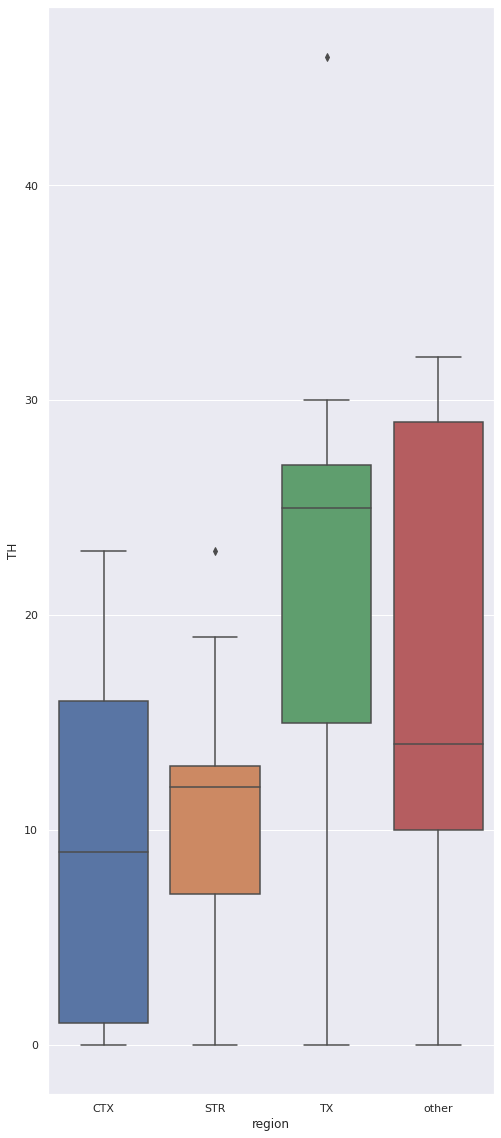

In [111]:
plt_df = pd.DataFrame(adata_pseudo.X, 
                      index = adata_pseudo.obs['cluster'], 
                      columns=adata_pseudo.var.index)
plt_df.reset_index(inplace=True)
plt_df['region'] = adata_pseudo.obs['region'].to_list()
plt_df['sample'] = adata_pseudo.obs['sample'].to_list()
# plt_df = plt_df[plt_df['sample'] != 'ST3_C2']  
# plt_df = plt_df[plt_df['sample'] != 'ST3_E2']

plt_df['sample_reg'] = plt_df['sample']  + '-' + plt_df['region']
plt_df = plt_df.groupby('sample_reg').sum()
plt_df['region'] = [x.split('-')[1] for x in plt_df.index]
print(plt_df['TH'])

sns.boxplot(data=plt_df, x='region', y='TH')
plt.show()

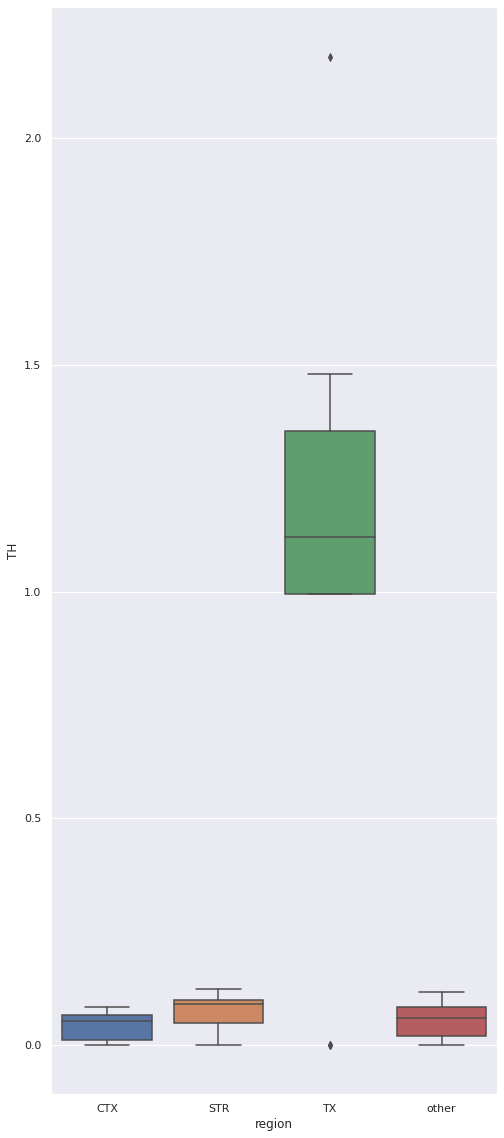

In [112]:
plt_df[adata_pseudo.var.index] = plt_df[adata_pseudo.var.index].div(plt_df[adata_pseudo.var.index].sum(axis=1), axis=0)
plt_df[adata_pseudo.var.index] *= 10000
sns.boxplot(data=plt_df, x='region', y='TH')
plt.show()

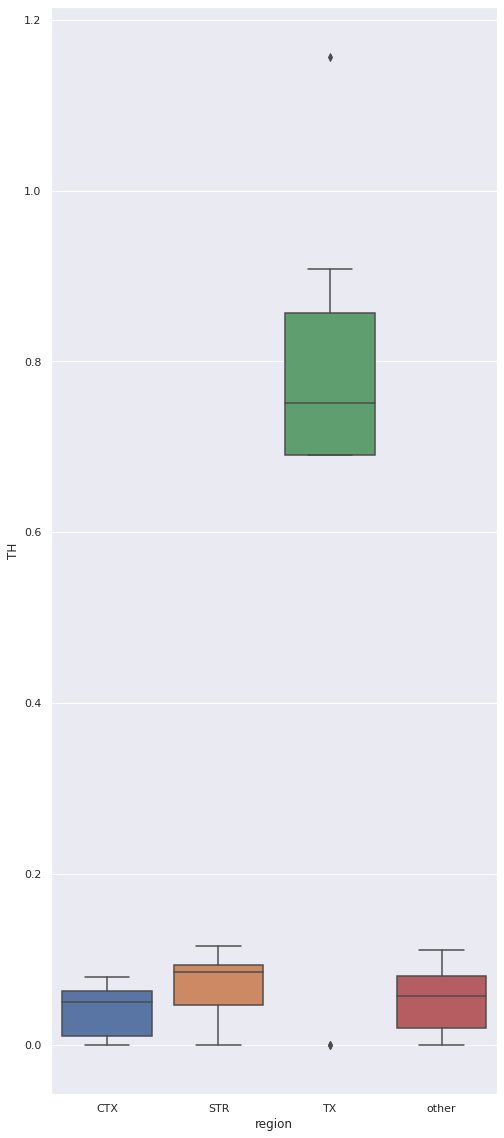

In [113]:
plt_df[adata_pseudo.var.index] = np.log1p(plt_df[adata_pseudo.var.index].to_numpy())
sns.boxplot(data=plt_df, x='region', y='TH')
plt.show()

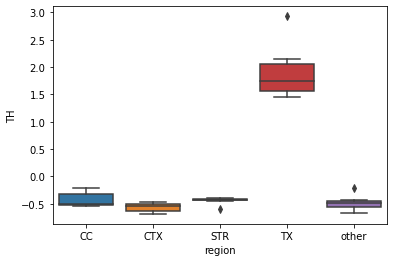

In [645]:
plt_df[adata_pseudo.var.index] = (plt_df[adata_pseudo.var.index] - plt_df[adata_pseudo.var.index].mean())/(plt_df[adata_pseudo.var.index].std()+0.0000000001)
sns.boxplot(data=plt_df, x='region', y='TH')
plt.show()

In [114]:
adata_pseudop_test = ad.AnnData(X=plt_df[adata_pseudo.var.index].to_numpy(),
                                var=pd.DataFrame(adata_pseudo.var.index),
                                obs=pd.DataFrame(plt_df['region']))
adata_pseudop_test.obs['sample'] =  [x.split('-')[0] for x in adata_pseudop_test.obs.index]                                       

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [115]:
sc.pp.highly_variable_genes(adata_pseudop_test, n_top_genes=3000, flavor='seurat', batch_key='sample', subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/prepr

    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [116]:
# adata_pseudop_test.var.sort_values(by='dispersions_norm')
adata_pseudop_test.var.index = adata_pseudop_test.var['gene_id']

In [123]:
adata_pseudop_test.var.sort_values(by='dispersions_norm')

gene_id  highly_variable     means  dispersions  dispersions_norm  \
gene_id                                                                        
TSG101      TSG101             True  0.629377    -4.313413         -0.642350   
MYO7B        MYO7B             True  0.444672    -4.344176         -0.587171   
TMEM33      TMEM33             True  0.555090    -4.274828         -0.535785   
ZFP142      ZFP142             True  0.237793    -4.514887         -0.532013   
COMMD9      COMMD9             True  0.518471    -4.313575         -0.501741   
...            ...              ...       ...          ...               ...   
HSP90AA1  HSP90AA1             True  1.337582     1.910610          3.372050   
HSPA8        HSPA8             True  0.970120     1.534364          3.396536   
TUBA1A      TUBA1A             True  1.202283     1.778333          3.427976   
MALAT1      MALAT1             True  0.938789     1.476287          3.428197   
GAPDH        GAPDH             True  1.174153     1.878764          3.458416   

          highly_variable_nbatches  highly_variable_intersection  
gene_id                                                           
TSG101                           4                         False  
MYO7B                            5                         False  
TMEM33                           4                         False  
ZFP142                           4                         False  
COMMD9                           4                         False  
...                            ...                           ...  
HSP90AA1                         9                          True  
HSPA8                            9                          True  
TUBA1A                           9                          True  
MALAT1                           9                          True  
GAPDH                            9                          True  

[3000 rows x 7 columns]

ranking genes
    finished: added to `.uns['wilcox']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


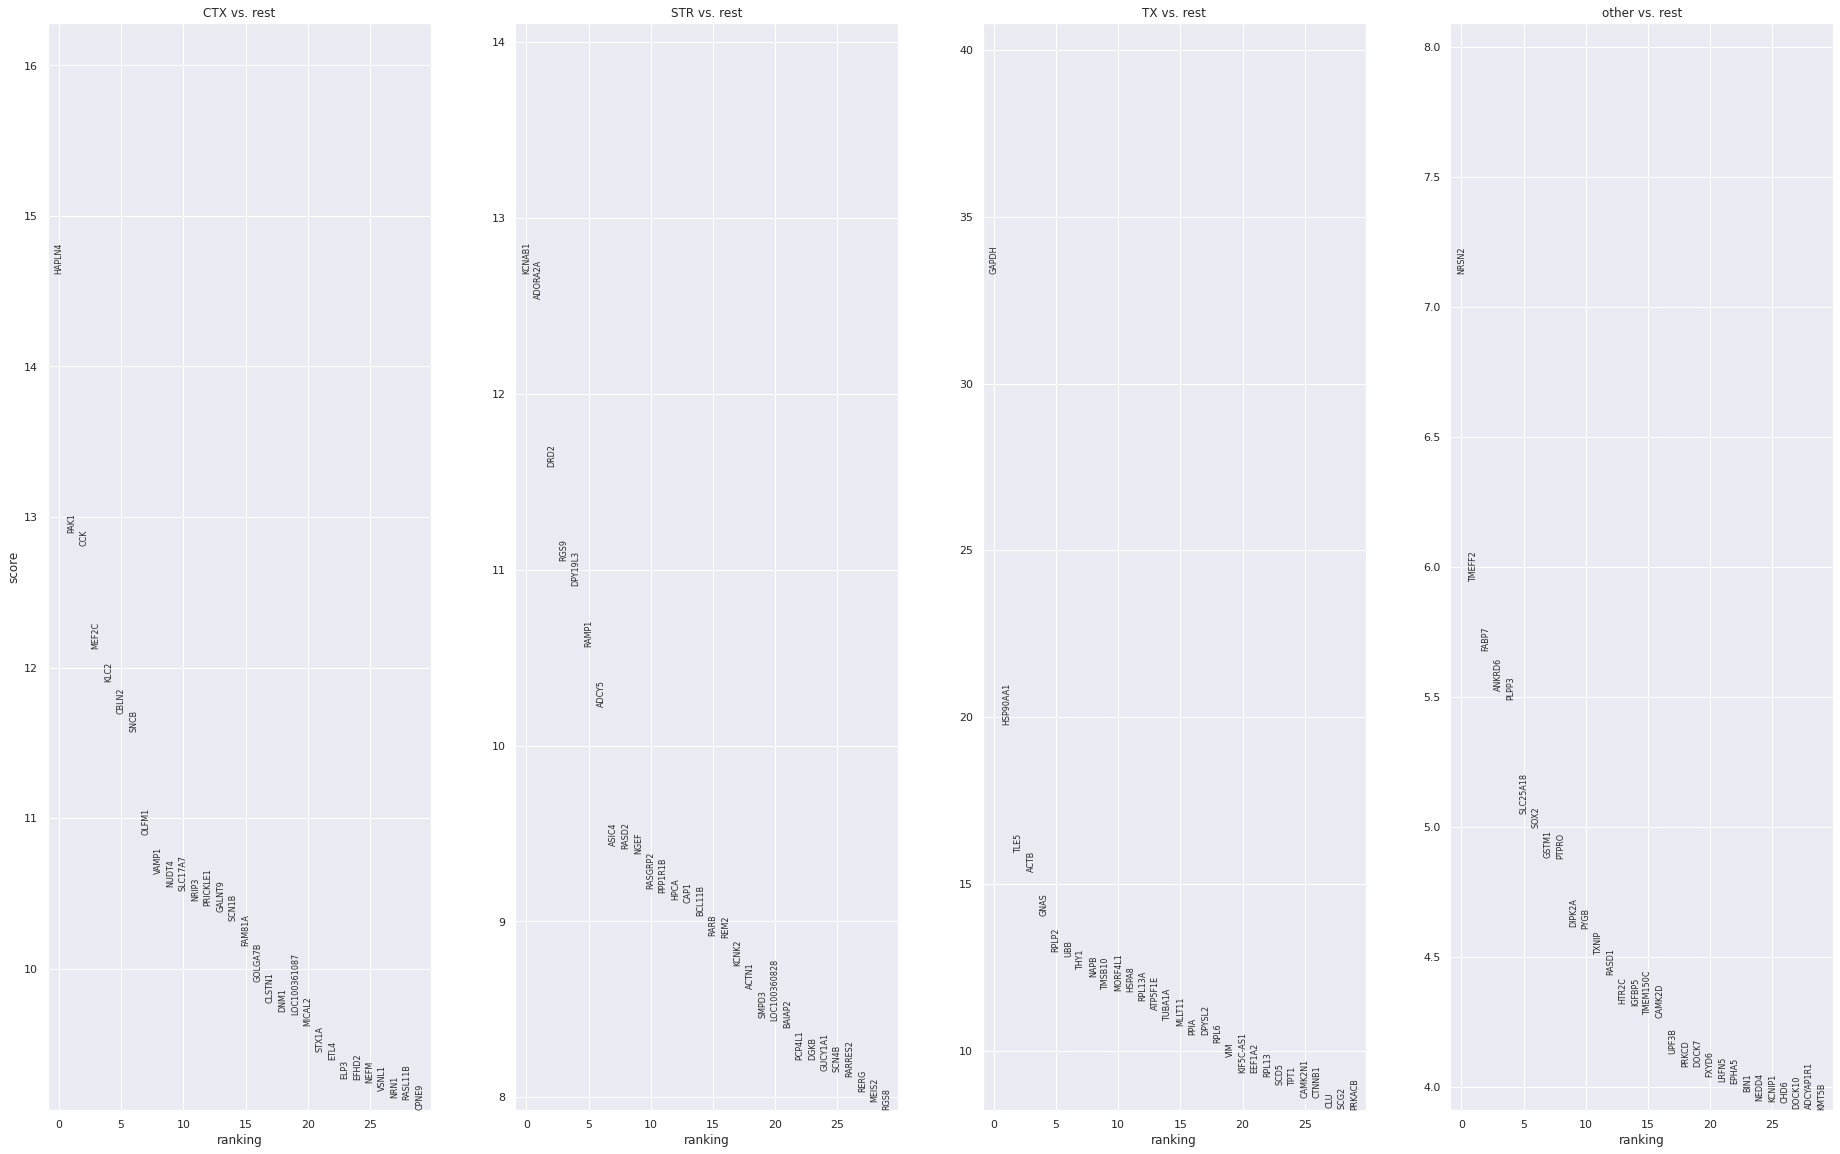

In [117]:
sc.tl.rank_genes_groups(adata_pseudop_test, 'region', 
#                         groups=['STR', 'TX', 'CC', 'CTX'], 
                        method='t-test', key_added="wilcox", 
                        corr_method='bonferroni', pts=True, use_raw=False)

sc.pl.rank_genes_groups(adata_pseudop_test, n_genes=30, sharey=False, key='wilcox')

In [55]:
adata_pseudop_test.uns['wilcox']['pts']

CTX       STR        TX     other
gene_id                                               
AABR07000398.1  1.000000  1.000000  1.000000  1.000000
AABR07006688.2  0.555556  0.555556  0.333333  0.555556
AABR07012054.1  0.333333  0.333333  0.111111  0.333333
AABR07021536.1  0.888889  0.888889  0.666667  0.888889
AABR07025010.1  1.000000  1.000000  1.000000  1.000000
...                  ...       ...       ...       ...
ZSWIM5          0.888889  0.888889  0.888889  0.888889
ZSWIM6          0.888889  0.888889  0.888889  0.888889
ZWINT           1.000000  1.000000  1.000000  1.000000
ZYX             1.000000  1.000000  1.000000  1.000000
ZZEF1           0.666667  0.666667  0.666667  0.666667

[3000 rows x 4 columns]

In [118]:
regions=adata_pseudop_test.obs['region'].unique()
columns = ['names', 'scores', 'logfoldchanges', 'pts' , 'pts_rest']
df_list = []
for region in regions:
    reg_df = pd.DataFrame()
    for col in columns:
        reg_df[col] = pd.DataFrame(adata_pseudop_test.uns['wilcox'][col])[region].to_list()
#         values = pd.DataFrame(adata_pseudop_test.uns['wilcox']['scores'])[region]
#         lfc = pd.DataFrame(adata_pseudop_test.uns['wilcox']['logfoldchanges'])[region]
#         pct = pd.DataFrame(adata_pseudop_test.uns['wilcox']['pts'])[region]
#         pct_out = pd.DataFrame(adata_pseudop_test.uns['wilcox']['pts_rest'])[region]
    df_list.append(reg_df)
    reg_df['region'] = region
    reg_df.index = reg_df['names']
df_list[2]
# pd.DataFrame([genes, values, lfc], columns = []).dropna(axis=1).transpose().iloc[:55, :].reset_index(drop=True)

names     scores  logfoldchanges       pts  pts_rest region
names                                                                   
GAPDH        GAPDH  33.286732        4.699169  1.000000  1.000000     TX
HSP90AA1  HSP90AA1  19.771441        4.107873  0.222222  0.444444     TX
TLE5          TLE5  15.936396        4.304092  0.333333  0.555556     TX
ACTB          ACTB  15.368260        2.137244  0.222222  0.333333     TX
GNAS          GNAS  14.049060        2.821905  0.555556  0.888889     TX
...            ...        ...             ...       ...       ...    ...
NDUFB5      NDUFB5  -6.871831       -0.521970  1.000000  1.000000     TX
TBPL1        TBPL1  -7.088917       -0.985618  0.555556  0.555556     TX
PTPN4        PTPN4  -7.409345       -0.972799  0.888889  0.888889     TX
GRIA3        GRIA3  -7.489764       -0.822509  0.888889  0.888889     TX
DLD            DLD  -8.116061       -0.801152  1.000000  1.000000     TX

[3000 rows x 6 columns]

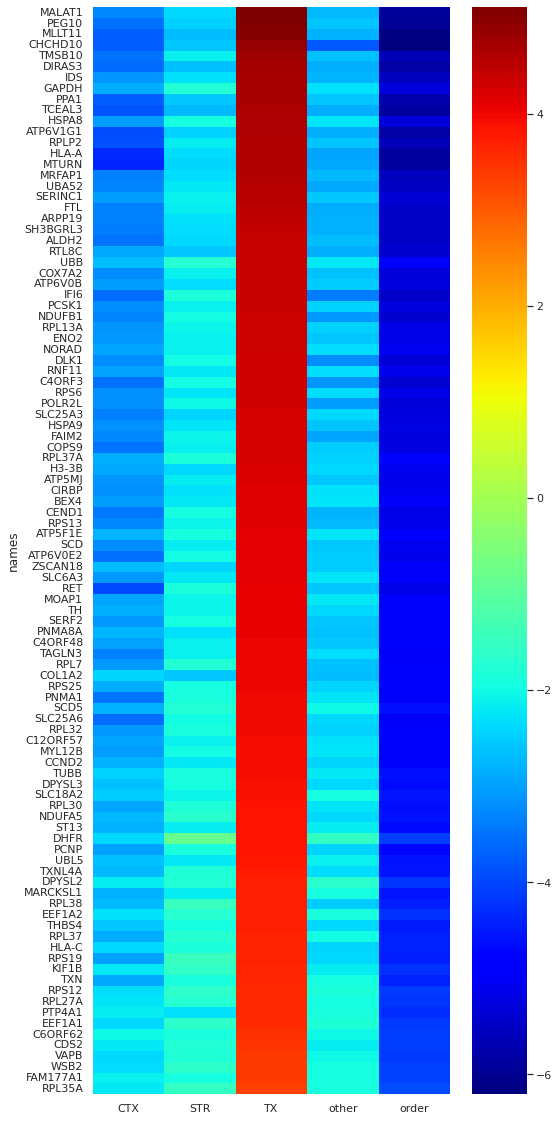

In [120]:
df_list[2] = df_list[2][df_list[2]['pts'] > 0.75]
df_list[2].sort_values(by='logfoldchanges', ascending=False).iloc[:55, :]
ref_genes = df_list[2].sort_values(by='logfoldchanges', ascending=False).index
compare_df = pd.DataFrame(index=ref_genes)
for df in df_list:
    temp = pd.DataFrame(df['logfoldchanges'])
    temp.columns=[df['region'].unique()[0]]
    compare_df = pd.merge(compare_df, temp, 
                          left_index=True, right_index=True)
compare_df['order'] = compare_df.subtract(compare_df['TX'], axis=0).mean(axis=1)
# compare_df = compare_df.sort_values(by='order')

sns.set(rc={'figure.figsize':(8,20)})
sns.heatmap(compare_df.iloc[:100, :], cmap='jet', yticklabels=True, ); plt.show()

In [47]:
pd.DataFrame(adata_pseudop_test.uns['wilcox']['names']), pd.DataFrame(adata_pseudop_test.uns['wilcox']['scores'])

(          CTX      STR            TX     other
 0         CCK  ADORA2A         GAPDH    HAPLN4
 1        CCN3   KCNAB1      HSP90AA1  SLC25A18
 2     SLC17A7     RGS9          TLE5     VAMP1
 3       TTC9B     DRD2          ACTB      PYGB
 4        DNM1    RAMP1          GNAS      PAK1
 ...       ...      ...           ...       ...
 2995     APOE    NPTXR          EGR1      RGS9
 2996    LYPD1   GABBR2        ANXA11   DPY19L3
 2997     PDYN    APBB1  LOC100361087     RAMP1
 2998      NTS     NRN1          AAK1      RBP4
 2999   NECAB2    VSNL1           DLD     NXPH4
 
 [3000 rows x 4 columns],
             CTX        STR         TX     other
 0     12.450398  12.665380  27.474100  8.603689
 1      9.825080  11.692959  18.998074  7.081758
 2      9.717738  10.923186  13.840174  7.035968
 3      9.090416  10.916410  13.276645  6.967734
 4      8.897199  10.873166  12.949708  6.927157
 ...         ...        ...        ...       ...
 2995  -5.830327  -7.788755  -7.275629 -4.833488
 299

In [800]:
adata_pseudop_test.uns['rank_genes_groups_filtered']


{'params': {'groupby': 'region',
  'reference': 'rest',
  'method': 't-test_overestim_var',
  'use_raw': False,
  'layer': None,
  'corr_method': 'bonferroni'},
 'names': rec.array([(nan, nan, nan, 'GAPDH', nan),
            ('PPP1R14A', 'STAC2', nan, 'HSP90AA1', nan),
            (nan, nan, 'ADORA2A', 'TLE5', 'PRKCD'), ...,
            (nan, nan, nan, nan, nan), (nan, nan, nan, nan, nan),
            (nan, nan, nan, nan, nan)],
           dtype=[('CC', 'O'), ('CTX', 'O'), ('STR', 'O'), ('TX', 'O'), ('other', 'O')]),
 'scores': rec.array([(11.024089 ,  9.0137   ,  9.5368395, 28.51634  ,  8.254021 ),
            (10.788114 ,  8.666916 ,  8.821792 , 17.658606 ,  6.3924766),
            (10.081429 ,  8.545242 ,  8.657755 , 15.400169 ,  5.679102 ),
            ...,
            (-5.5797024, -3.7597215, -3.4620714, -4.753527 , -3.4325829),
            (-6.043356 , -4.3527393, -3.6415665, -4.8764844, -3.7938895),
            (-6.769935 , -5.325264 , -3.646034 , -5.701036 , -3.999026 )],
     

In [796]:
sc.tl.filter_rank_genes_groups(adata_pseudop_test, key="wilcox", 
                                   groupby='region', 
                                   use_raw=False, 
                                   key_added='rank_genes_groups_filtered', 
                                   min_in_group_fraction=0.25, 
                                   min_fold_change=1.5,
                                   max_out_group_fraction=2, 
                                   compare_abs=False)


Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 1.5, max_out_group_fraction: 2


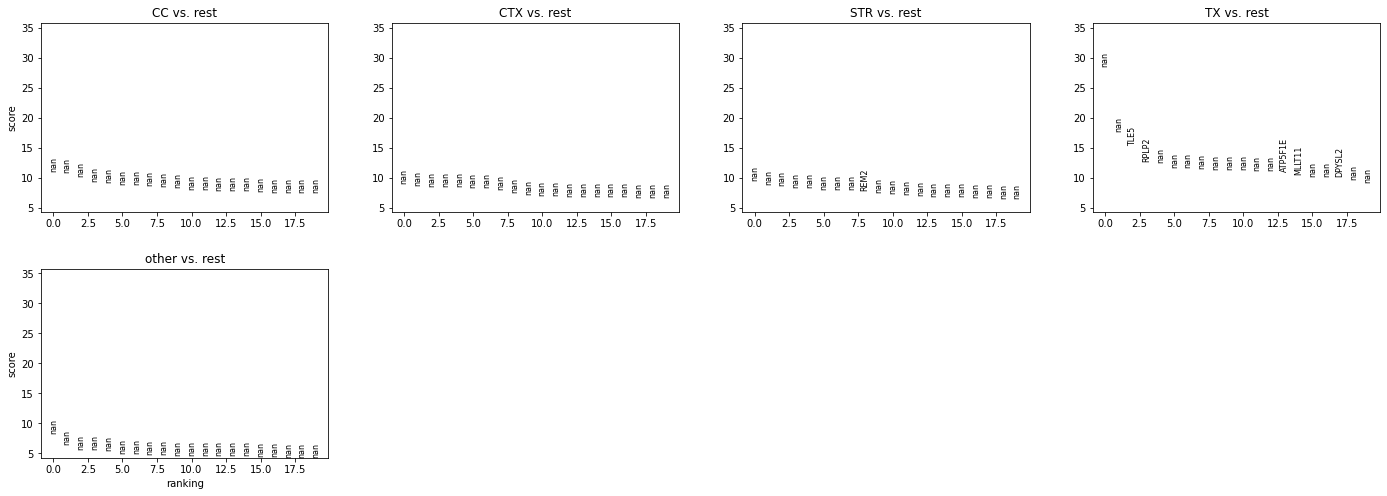

In [783]:
sc.pl.rank_genes_groups(adata_pseudop_test, key='rank_genes_groups_filtered')

/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/home/lcadmin/miniconda3/envs/ST_pipeline/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hv

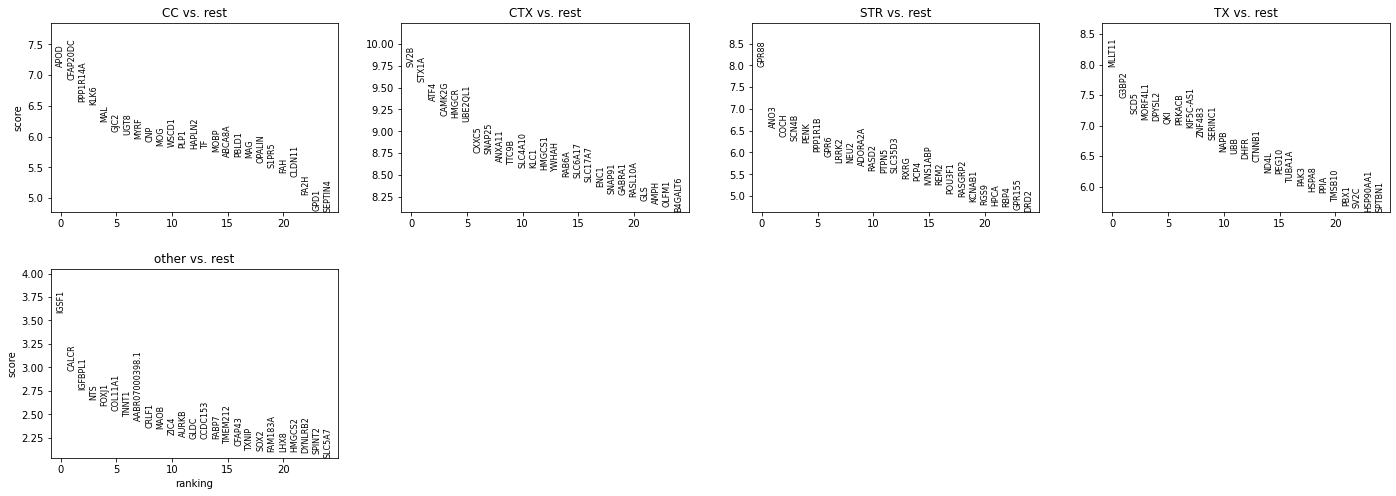

In [81]:
sc.pp.highly_variable_genes(adata_pseudo, flavor='seurat', batch_key='sample', subset=True)
top_hvg = adata_pseudo.var.sort_values(by='dispersions_norm', ascending=False)

## uncomment the following line if you want to remove all 'other' areas
#nonpartial_adata = nonpartial_adata[nonpartial_adata.obs[nonpartial_adata.uns['regions']].max(axis=1) == 1, :]

sc.tl.rank_genes_groups(adata_pseudo, 'region', method='t-test', key_added="t-test", use_raw=True)
sc.pl.rank_genes_groups(adata_pseudo, n_genes=25, sharey=False, key="t-test")

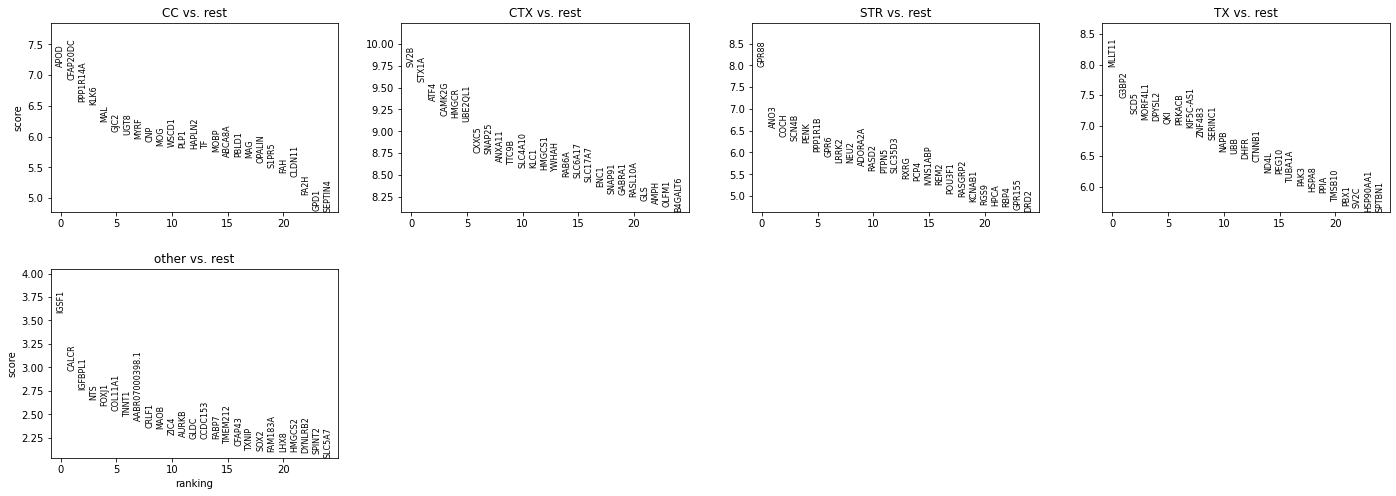

In [82]:
sc.tl.rank_genes_groups(adata_pseudo, 'region', method='t-test', key_added="t-test", use_raw=True)
sc.pl.rank_genes_groups(adata_pseudo, n_genes=25, sharey=False, key="t-test")

categories: CC, CTX, STR, etc.
var_group_labels: TX


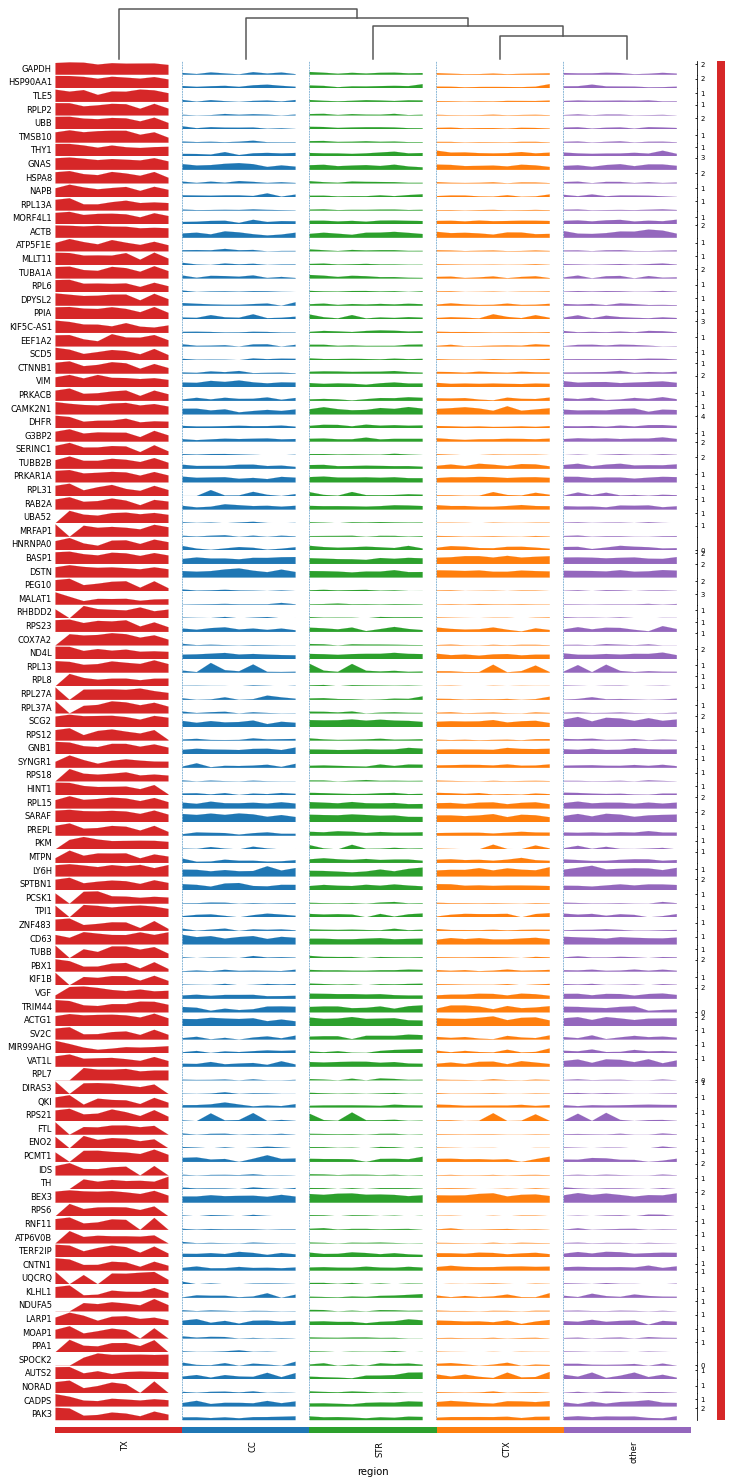

KeyError: "Could not find keys '['nan']' in columns of `adata.obs` or in adata.var_names."

In [753]:
focus_region = False
if 'SN' in adata_pseudo.uns['regions_dict'].values():
    focus_region = 'SN'
    contrast_region = 'other'
elif 'TX' in adata_pseudo.uns['regions_dict'].values():
    focus_region = 'TX'
    contrast_region = 'STR'
    
if focus_region:
    sc.pl.rank_genes_groups_tracksplot(adata_pseudop_test, groupby='region', 
                                       key="rank_genes_groups_filtered", groups=[focus_region],
                                       n_genes=100, save=False)
    #sc.pl.rank_genes_groups_heatmap(adata_pseudo, groupby='region', key="t-test", groups=['SN'], n_genes=100, save=False, standard_scale='var', show_gene_labels=True)
    sc.pl.heatmap(adata_pseudop_test,
                  var_names=list(adata_pseudop_test.uns['rank_genes_groups_filtered']['names'][focus_region][:25])\
                  + list(adata_pseudop_test.uns['rank_genes_groups_filtered']['names'][contrast_region][:10]),
                  groupby='region', standard_scale='var', var_group_rotation=90,
#                   save=f'heatmap_{focus_region}-{contrast_region}_DEG_sum.pdf', 
                  save=False,
                  show_gene_labels=True,
                  swap_axes=True)
